In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import sys
import scanpy as sc
from pyprojroot import here
import session_info

**Parameters**

In [3]:
path = "./03_Downstream_Analysis/01_Gene_Universe_Definition/results/04_MAIN_geneUniverse.h5ad"

# Load object

In [11]:
varDF = pd.read_csv(here('03_Downstream_Analysis/04_SPECTRA/results/varDF.csv'), index_col=0)
varDF.head()

,hgnc_id,symbol,locus_group,HUGO_status,mt,ribo,hb,plt
ensembl_gene_id,,,,,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein_coding,official,False,False,False,False
ENSG00000000419,HGNC:3005,DPM1,protein_coding,official,False,False,False,False
ENSG00000000457,HGNC:19285,SCYL3,protein_coding,official,False,False,False,False
ENSG00000000460,HGNC:25565,FIRRM,protein_coding,official,False,False,False,False
ENSG00000000938,HGNC:3697,FGR,protein_coding,official,False,False,False,False


In [4]:
adata = sc.read_h5ad(path)

In [5]:
adata

AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'

# Generate table

In [7]:
def calculate_expression_percentage(adata_subset):
    # Boolean matrix of gene expression (expressed = at least 1 count)
    expression_matrix = adata_subset.X > 0
    # Calculate the percentage of cells expressing each gene
    percentage_expressed = expression_matrix.mean(axis=0) * 100
    # Create a DataFrame with genes as row names
    df = pd.DataFrame(percentage_expressed.T, index=adata_subset.var_names, columns=['% cells'])
    return df


In [8]:
expression_dict = {}

# Get unique values of Level1
unique_level1 = adata.obs['Level1'].unique()

# Loop through each unique value in Level1 and calculate expression percentages
for level in unique_level1:
    print(f"*** {} ***".(level))
    # Subset the adata object
    adata_subset = adata[adata.obs['Level1'] == level]
    # Calculate the percentage of cells expressing each gene
    df = calculate_expression_percentage(adata_subset)
    # Store the result in the dictionary
    expression_dict[level] = df

In [12]:
for key in expression_dict:
    df = expression_dict[key]
    # Merge with varDF to get the symbols
    df = df.merge(varDF[['symbol']], left_index=True, right_index=True, how='left')
    # Reorder columns to have 'symbol' as the first column
    df = df[['symbol', '% cells']]
    # Update the dictionary with the new dataframe
    expression_dict[key] = df

In [18]:
expression_dict["B"]

,symbol,% cells
ensembl_gene_id,,
ENSG00000000003,TSPAN6,0.110403
ENSG00000000457,SCYL3,7.199460
ENSG00000000938,FGR,11.833028
ENSG00000000971,CFH,0.049317
ENSG00000001036,FUCA2,2.309499
...,...,...
ENSG00000278817,ENSG00000278817,0.103398
ENSG00000278828,H3C10,1.601966
ENSG00000280670,CCDC163,0.592086


/scratch_tmp/25937826/ipykernel_84278/2388071121.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['% cells'], shade=True, ax=ax)
/scratch_tmp/25937826/ipykernel_84278/2388071121.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['% cells'], shade=True, ax=ax)
/scratch_tmp/25937826/ipykernel_84278/2388071121.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['% cells'], shade=True, ax=ax)
/scratch_tmp/25937826/ipykernel_84278/2388071121.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplo

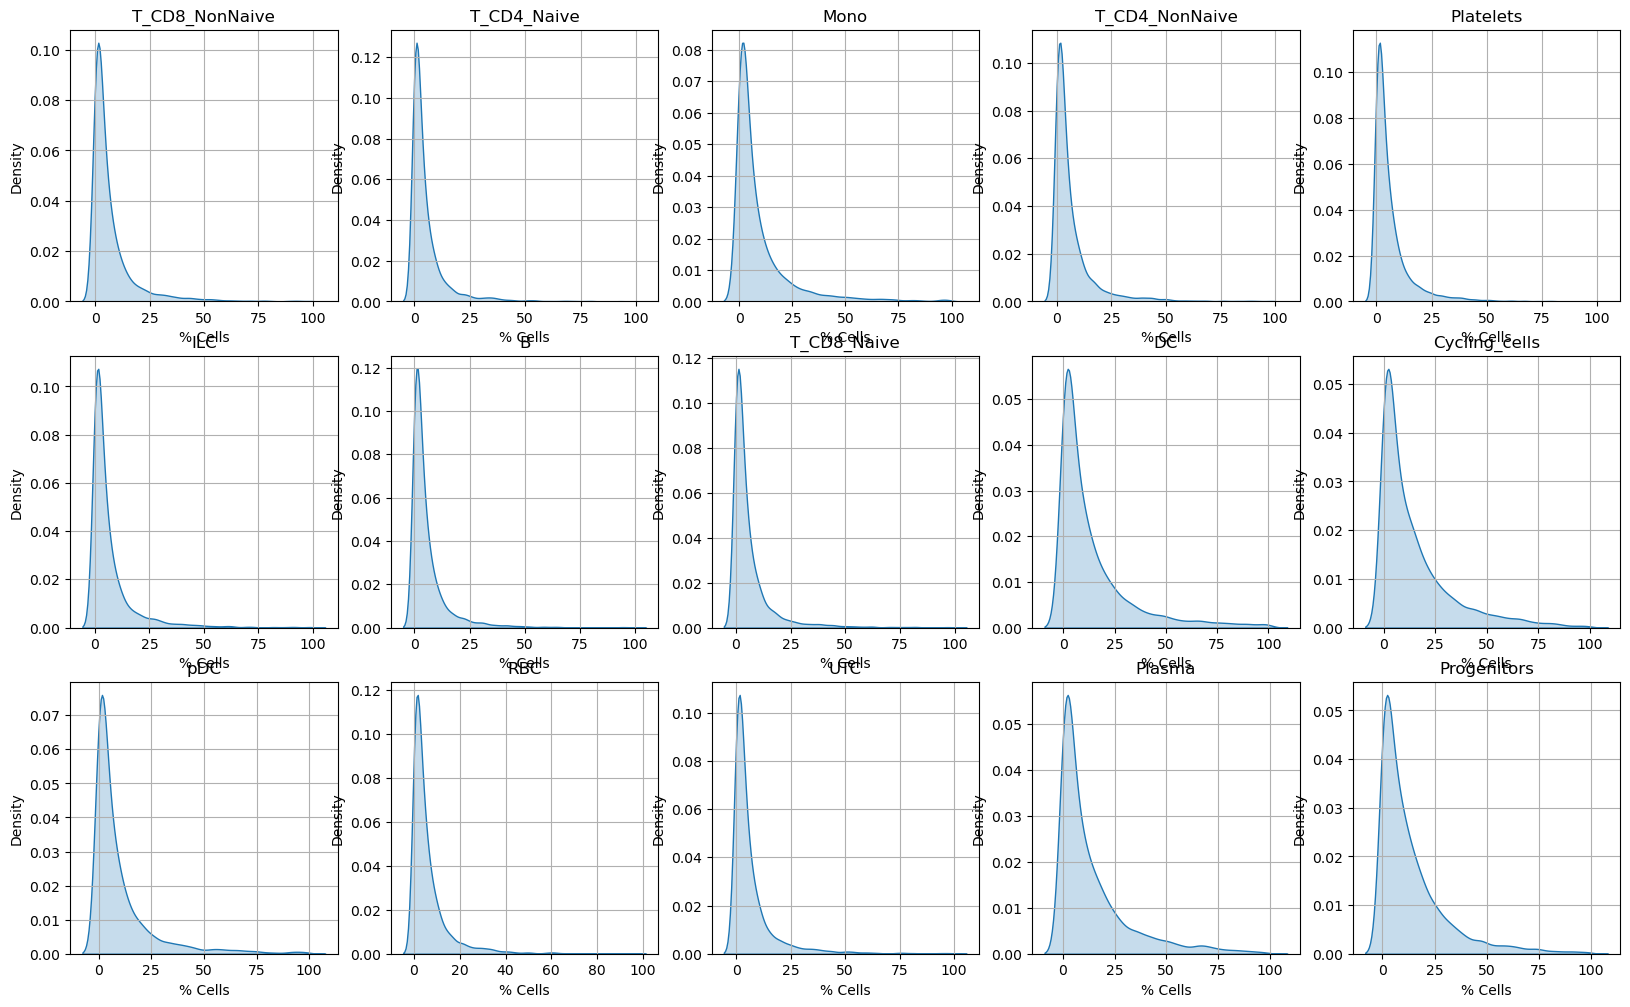

In [17]:
n_cols = 5
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

for ax, (celltype, df) in zip(axes, expression_dict.items()):
    sns.kdeplot(df['% cells'], shade=True, ax=ax)
    ax.set_title(f'{celltype}')
    ax.set_xlabel('% Cells')
    ax.set_ylabel('Density')
    ax.grid(True)


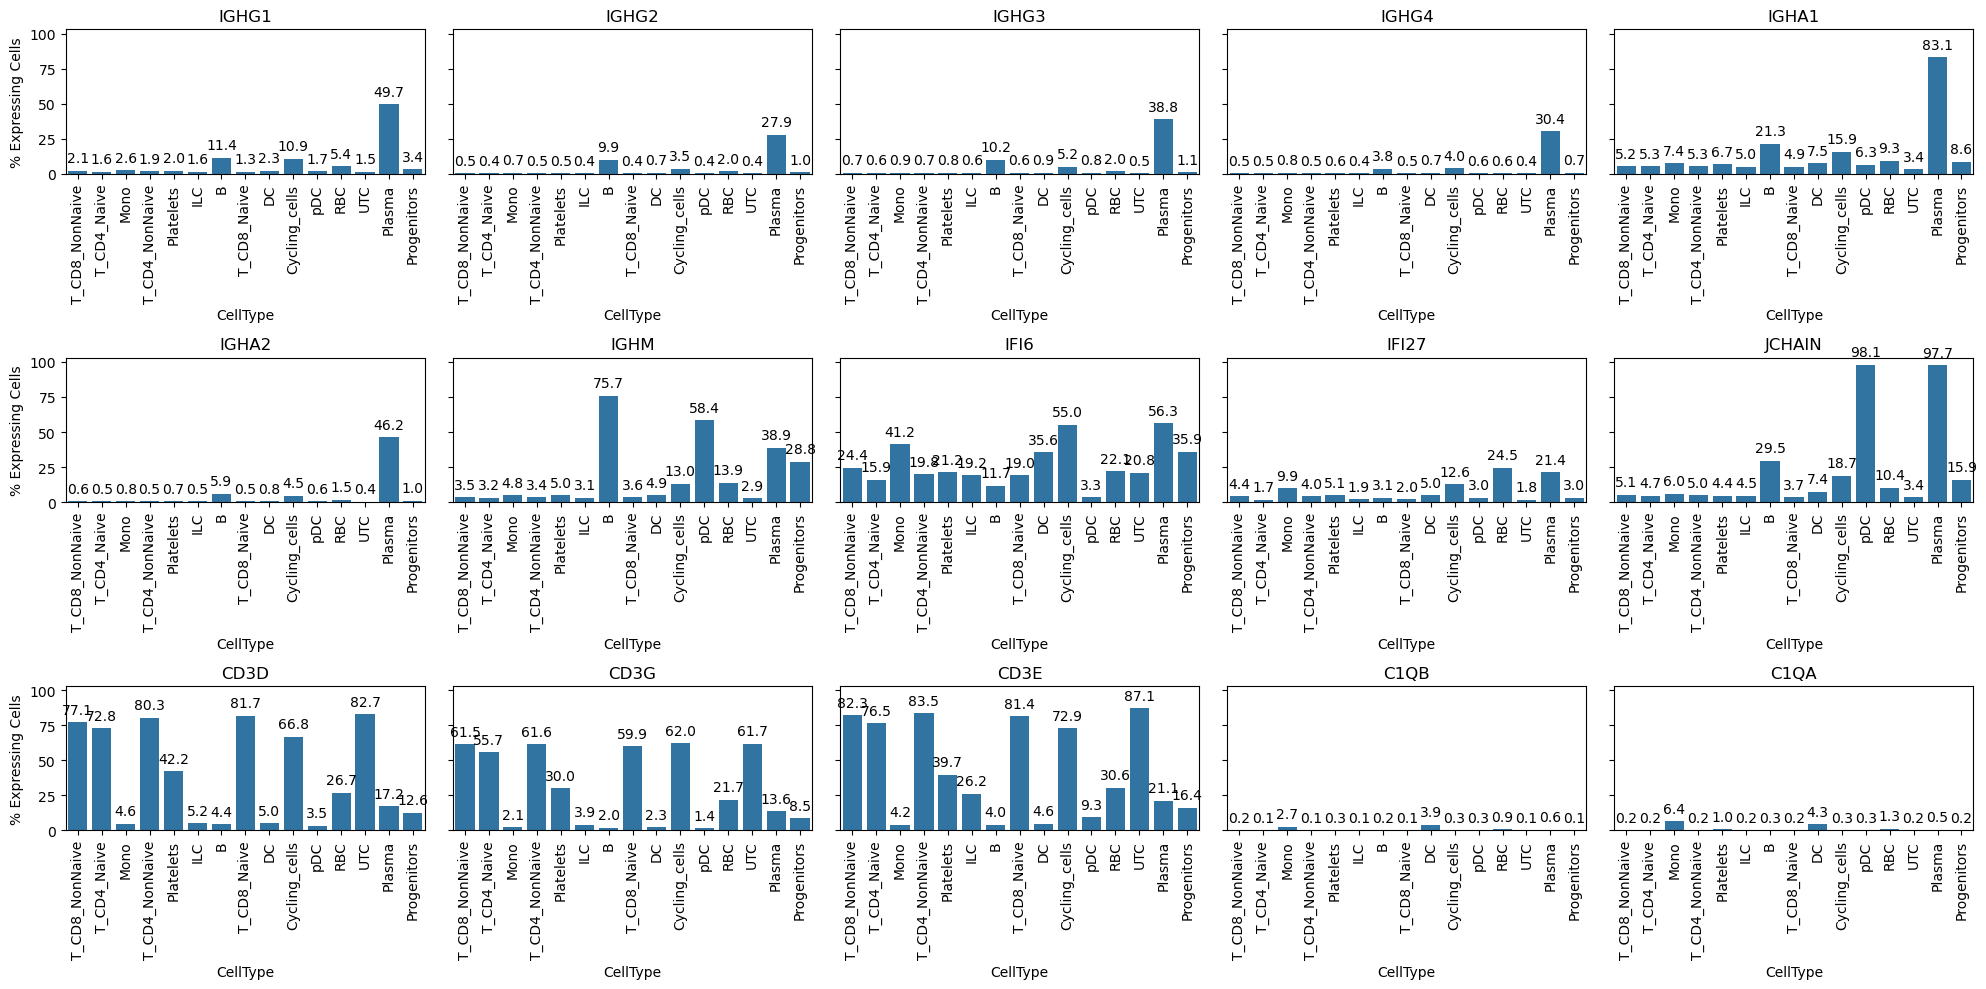

In [35]:
for celltype, df in expression_dict.items():
    df['CellType'] = celltype

combined_df = pd.concat(expression_dict.values())

# Filter for the genes to plot
genes_to_plot = ["IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHA1", "IGHA2", "IGHM", "IFI6", "IFI27","JCHAIN", "CD3D", "CD3G", "CD3E", "C1QB", "C1QA"]
filtered_df = combined_df[combined_df['symbol'].isin(genes_to_plot)]

# Generate the barplot
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for ax, gene in zip(axes, genes_to_plot):
    sns.barplot(data=filtered_df[filtered_df['symbol'] == gene], x='CellType', y='% cells', ax=ax)
    ax.set_title(gene)
    ax.set_xlabel('CellType')
    ax.set_ylabel('% Expressing Cells')
    ax.tick_params(axis='x', rotation=90)
    
    # Add value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()


In [ ]:
for celltype, df in expression_dict.items():
    df['CellType'] = celltype

combined_df = pd.concat(expression_dict.values())

In [32]:
path = here("03_Downstream_Analysis/07_SHAP/results/genes_expressing_cells.csv")

In [33]:
combined_df.to_csv(path, index=False)